In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-13 14:14:41.698599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-13 14:14:44.219427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 14:14:44.222033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-13 14:14:44.601095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 14:14:44.603620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13391, 512, 512, 1) (13391, 512, 512, 1) (3375, 512, 512, 1) (3375, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13391, 512, 512, 1) (3375, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(524, 512, 512, 1) (524, 512, 512, 1) (524, 512, 512, 1)


In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [14]:
m_train.dtype

dtype('float64')

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
#train_images_array = train_images_array.astype(np.float32)

In [18]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [19]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [22]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [23]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [24]:
#test_images_array = test_images_array.astype(np.float32)

In [25]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [26]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [27]:
#y_train_set = y_train_set.astype(np.float32)

In [28]:
#y_val = y_val.astype(np.float32)

In [29]:
X_train_set.dtype, y_train_set.dtype

(dtype('float64'), dtype('float64'))

In [30]:
X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'))

In [31]:
test_images_array.dtype, y_test.dtype

(dtype('float64'), dtype('float64'))

In [32]:
X_val.shape, y_val.shape

((122, 512, 512, 1), (122, 512, 512, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-13 14:17:57.165547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 14:17:57.168106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 14:17:57.177958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-13 14:17:57.180908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 14:17:57.183430: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-13 14:17:58.247381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-13 14:17:58.266770: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-13 14:17:59.607818: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-13 14:18:00.485035: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-13 14:18:01.641123: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-13 14:18:01.641148: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-13 14:18:01.641492: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-13 14:18:01.734996: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-13 14:18:02.898603: I tensorflow/stream_exec

12/12 [==============================] - 43s 2s/step - loss: 0.5057 - iou: 1.5903e-04 - iou_thresholded: 6.9928e-04 - val_loss: 0.0817 - val_iou: 7.7201e-04 - val_iou_thresholded: 7.7659e-04
Epoch 2/200
12/12 [==============================] - 24s 1s/step - loss: 0.0158 - iou: 4.5467e-04 - iou_thresholded: 8.5709e-04 - val_loss: 0.0020 - val_iou: 6.1099e-04 - val_iou_thresholded: 7.7659e-04
Epoch 3/200
12/12 [==============================] - 12s 977ms/step - loss: 0.0014 - iou: 0.0023 - iou_thresholded: 7.8471e-04 - val_loss: 0.0022 - val_iou: 0.0059 - val_iou_thresholded: 7.7659e-04
Epoch 4/200
12/12 [==============================] - 12s 980ms/step - loss: 9.9486e-04 - iou: 0.0078 - iou_thresholded: 8.2399e-04 - val_loss: 0.0020 - val_iou: 0.0101 - val_iou_thresholded: 7.7659e-04
Epoch 5/200
12/12 [==============================] - 12s 978ms/step - loss: 9.6234e-04 - iou: 0.0096 - iou_thresholded: 8.5502e-04 - val_loss: 0.0018 - val_iou: 0.0131 - val_iou_thresholded: 7.7659e-04
Epoc

Epoch 43/200
12/12 [==============================] - 12s 973ms/step - loss: 3.5951e-04 - iou: 0.3202 - iou_thresholded: 0.4526 - val_loss: 9.9584e-04 - val_iou: 0.2334 - val_iou_thresholded: 0.4410
Epoch 44/200
12/12 [==============================] - 12s 974ms/step - loss: 3.4839e-04 - iou: 0.3542 - iou_thresholded: 0.4893 - val_loss: 9.2237e-04 - val_iou: 0.2825 - val_iou_thresholded: 0.4510
Epoch 45/200
12/12 [==============================] - 12s 976ms/step - loss: 3.4572e-04 - iou: 0.3310 - iou_thresholded: 0.4799 - val_loss: 0.0011 - val_iou: 0.2278 - val_iou_thresholded: 0.3832
Epoch 46/200
12/12 [==============================] - 12s 978ms/step - loss: 3.5326e-04 - iou: 0.3423 - iou_thresholded: 0.4777 - val_loss: 0.0010 - val_iou: 0.2774 - val_iou_thresholded: 0.4590
Epoch 47/200
12/12 [==============================] - 12s 975ms/step - loss: 3.1958e-04 - iou: 0.3706 - iou_thresholded: 0.5248 - val_loss: 0.0010 - val_iou: 0.2755 - val_iou_thresholded: 0.4433
Epoch 48/200
12/1

Epoch 85/200
12/12 [==============================] - 12s 975ms/step - loss: 2.0829e-04 - iou: 0.5242 - iou_thresholded: 0.6554 - val_loss: 0.0012 - val_iou: 0.3816 - val_iou_thresholded: 0.5344
Epoch 86/200
12/12 [==============================] - 12s 976ms/step - loss: 2.0871e-04 - iou: 0.5256 - iou_thresholded: 0.6527 - val_loss: 0.0011 - val_iou: 0.4049 - val_iou_thresholded: 0.5357
Epoch 87/200
12/12 [==============================] - 12s 975ms/step - loss: 1.7333e-04 - iou: 0.5588 - iou_thresholded: 0.6795 - val_loss: 0.0013 - val_iou: 0.4006 - val_iou_thresholded: 0.5495
Epoch 88/200
12/12 [==============================] - 12s 975ms/step - loss: 1.8379e-04 - iou: 0.5517 - iou_thresholded: 0.6747 - val_loss: 0.0012 - val_iou: 0.3949 - val_iou_thresholded: 0.5440
Epoch 89/200
12/12 [==============================] - 12s 975ms/step - loss: 2.0033e-04 - iou: 0.5579 - iou_thresholded: 0.6771 - val_loss: 0.0010 - val_iou: 0.3953 - val_iou_thresholded: 0.5491
Epoch 90/200
12/12 [=====

Epoch 127/200
12/12 [==============================] - 12s 980ms/step - loss: 9.6307e-05 - iou: 0.7585 - iou_thresholded: 0.8326 - val_loss: 0.0013 - val_iou: 0.4685 - val_iou_thresholded: 0.5236
Epoch 128/200
12/12 [==============================] - 12s 980ms/step - loss: 1.0222e-04 - iou: 0.7396 - iou_thresholded: 0.8305 - val_loss: 0.0013 - val_iou: 0.4667 - val_iou_thresholded: 0.5214
Epoch 129/200
12/12 [==============================] - 12s 977ms/step - loss: 9.9349e-05 - iou: 0.7474 - iou_thresholded: 0.8322 - val_loss: 0.0014 - val_iou: 0.4633 - val_iou_thresholded: 0.5120
Epoch 130/200
12/12 [==============================] - 12s 975ms/step - loss: 8.9171e-05 - iou: 0.7761 - iou_thresholded: 0.8523 - val_loss: 0.0013 - val_iou: 0.4730 - val_iou_thresholded: 0.5198
Epoch 131/200
12/12 [==============================] - 12s 1s/step - loss: 8.9311e-05 - iou: 0.7717 - iou_thresholded: 0.8545 - val_loss: 0.0013 - val_iou: 0.4593 - val_iou_thresholded: 0.5057
Epoch 132/200
12/12 [==

Epoch 169/200
12/12 [==============================] - 12s 976ms/step - loss: 5.4540e-05 - iou: 0.8738 - iou_thresholded: 0.9343 - val_loss: 0.0019 - val_iou: 0.4784 - val_iou_thresholded: 0.4937
Epoch 170/200
12/12 [==============================] - 12s 1s/step - loss: 5.3890e-05 - iou: 0.8980 - iou_thresholded: 0.9441 - val_loss: 0.0018 - val_iou: 0.4922 - val_iou_thresholded: 0.5098
Epoch 171/200
12/12 [==============================] - 12s 1s/step - loss: 3.6889e-05 - iou: 0.9012 - iou_thresholded: 0.9533 - val_loss: 0.0020 - val_iou: 0.4854 - val_iou_thresholded: 0.4984
Epoch 172/200
12/12 [==============================] - 12s 977ms/step - loss: 5.5396e-05 - iou: 0.8898 - iou_thresholded: 0.9353 - val_loss: 0.0020 - val_iou: 0.4894 - val_iou_thresholded: 0.5054
Epoch 173/200
12/12 [==============================] - 12s 976ms/step - loss: 5.0289e-05 - iou: 0.8834 - iou_thresholded: 0.9460 - val_loss: 0.0020 - val_iou: 0.4935 - val_iou_thresholded: 0.5079
Epoch 174/200
12/12 [=====

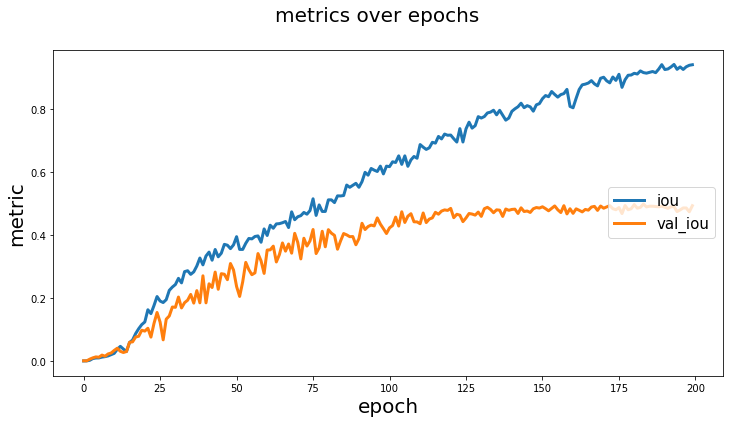

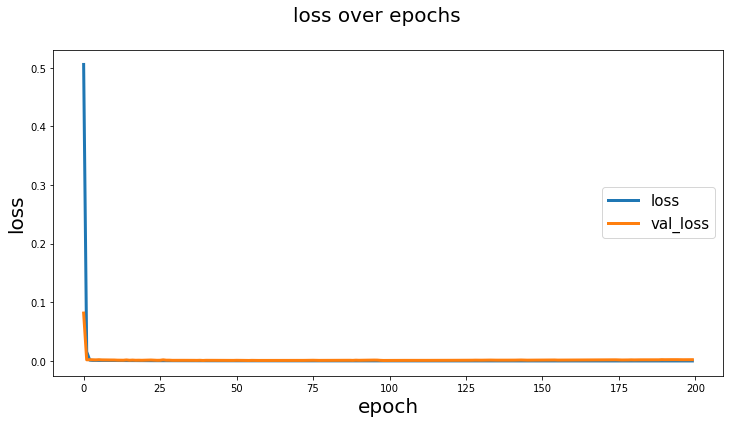

In [35]:
C.Helper.visualize_graph(history)

In [36]:
y_pred = C.Helper.prediction(test_images_array, model)

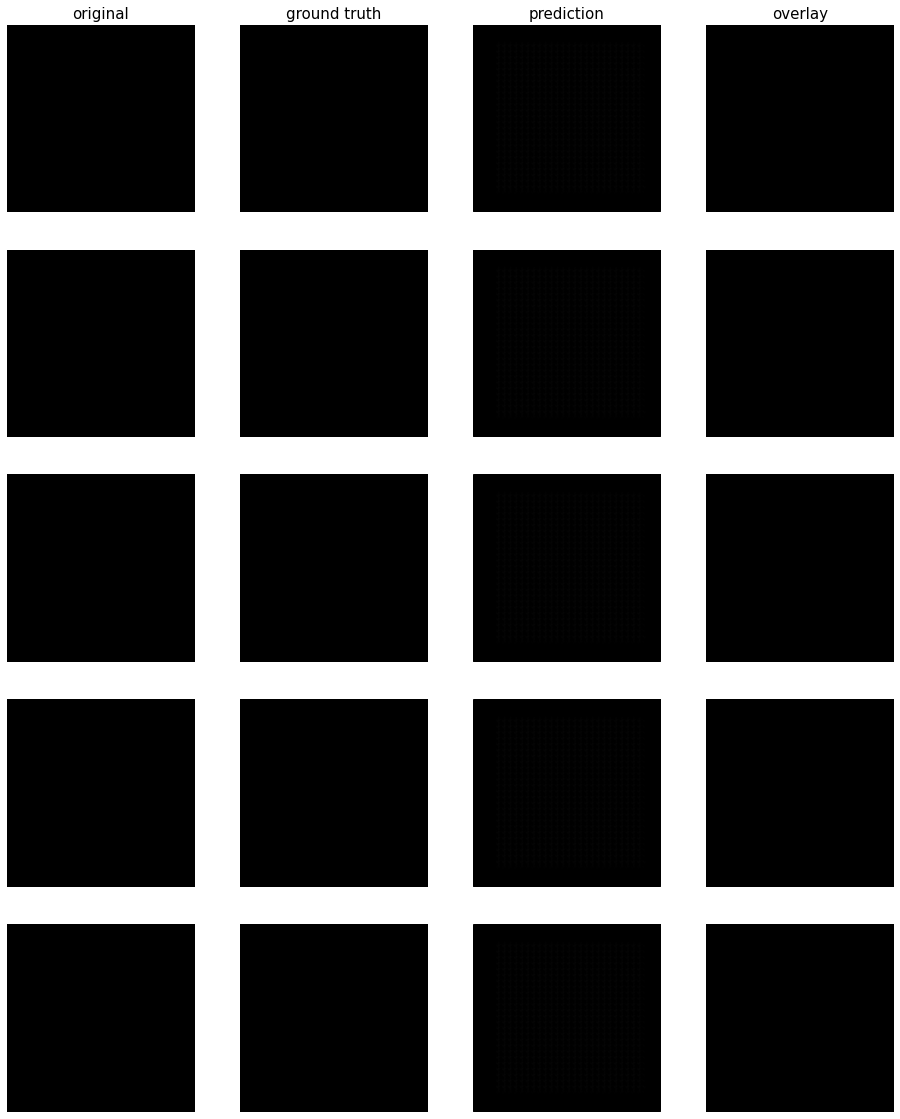

In [37]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [38]:
C.Helper.evaluate(test_images_array, y_test, model)

106/106 [==============================] - 23s 216ms/step - loss: 2.8328e-04 - iou: 0.1203 - iou_thresholded: 0.5614
